<a href="https://colab.research.google.com/github/alexv710/debias_cv_data/blob/main/DataPreprocessing_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import os
import datetime

import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import graphviz

# sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Data Preprocessing

In [2]:
# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

# read the mainsample.dta file for further processing 

data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

# Import the mainsample via StataReader to use variable_labels (old version of the read_stata)

data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

# Remove all columns in the dataset for which no labels exist
# Those are mostly columns needed for p-tests and some matrix calculations in
# Stata. The outputted labels are those that are kept in the data

data = data.drop(columns=['CVAxORIGINE_IM_12', 'CVAxZUS_CUCS', 'CVAxZetI', 'C', 'CVA0',\
                          'p_offre1', 'control_manquant', 'ZouI_pred', 'ZouI0', 'ALE_16'])

# Remove sampling weights (within and out of the experiment)

data = data.drop(columns='POIDS_SEL')

# Remove all the centered features

data = data.drop(columns=['FEMME_c', 'a30m_c', 'a3049_c', 'a50p_c', 'dip_aucun_c',\
                          'dip_bepcap_c', 'dip_bac_c', 'dip_bac2p_c', 'recherche_LD_c', 'recherche_TLD_c'])

# Remove all features that are not directly derivable from the CVs or that have missing data

data = data.drop(columns=['RECRUTE', 'REFUSAL', 'codage_cv', 'ORIGINE_IM_1', 'ORIGINE_IM_2',\
                          'ORIGINE_IM_12', 'ID_OFFRE', 'ID_CANDIDAT', 'travail_etranger', 'duree_expro_offre'])

# Remove additional features that seem to bring no value or are unclear in the methodology according to the original paper

data = data.drop(columns=['CV_hesit_', 'CV_hesit', 'CV_note_7p', 'ZetI', 'permis', 'CV_attrayant_'])

for key, value in data_labels.items():
    for col in data.columns:
        if key==col:
            # print(key, ':    ', value)
            if len(value)==0 or value.startswith('ID_OFFRE==') or value.startswith('Dummy for local job center'):
                data = data.drop(columns=col)

# clean up dataset nan values
# print(len(data))
# for item in data:
    # if data[item].isna().sum() > 0:
        # print(item, data[item].isna().sum())
        
# data.dropna(subset=['CV_note_7p', 'etudes_etranger', 'langue_anglais'],inplace=True)

data['CV_qualif_sup'] = data['CV_qualif_sup'].fillna(0)
data['CV_qualif_inf'] = data['CV_qualif_inf'].fillna(0)
data['PREN_MUSULMAN'] = data['PREN_MUSULMAN'].fillna(0)
data['ZUS_CUCS'] = data['ZUS_CUCS'].fillna(0)
data['recherche_TLD'] = data['recherche_TLD'].fillna(0)

data['etudes_etranger'] = data['etudes_etranger'].fillna(0)
data['langue_anglais'] = data['langue_anglais'].fillna(0)
data['langue_arabe'] = data['langue_arabe'].fillna(0)
data['langue_autres'] = data['langue_autres'].fillna(0)
data['CV_formation_'] = data['CV_formation_'].fillna(0)


# derived from CV_experience_3p

data['CV_experience_'] = data['CV_experience_'].fillna(0.5)


# fill with 1 since missing records are not in the other age groups

data['a26m'] = data['a26m'].fillna(1)

# Assign medium grade for all unknown records
data['CV_note_2'] = data['CV_note_2'].fillna(0)
data['CV_note_3'] = data['CV_note_3'].fillna(1)
data['CV_note_4'] = data['CV_note_4'].fillna(0)
data['CV_note_5'] = data['CV_note_5'].fillna(0)



# print(len(data))
for item in data:
    if data[item].isna().sum() > 0:
        print(item, data[item].isna().sum())

        
        
# Normalize remaining columns to values between 0 and 1
# call the min_max_scaling function

data = min_max_scaling(data)


CVA 203


In [3]:
# Create a dataframe for the anonymized and not anonymized data

X_ano = pd.DataFrame()
X_unano = pd.DataFrame()
X = pd.DataFrame()

for index, row in data.iterrows():
    if row['ENTRETIEN'] == 1:
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        
data.to_csv('fullData.csv')

for index, row in data.iterrows():
    if row['CVA'] == 1: 
        X_ano = X_ano.append(row)
    else:
        X_unano = X_unano.append(row)

# Assign the interviewed column to our target vector

y_ano = X_ano['ENTRETIEN']
y_unano = X_unano['ENTRETIEN']
y = data['ENTRETIEN']

# Drop the Interviewed/hired & anonymized columns (hired is much dependend on the number of jobs available
# and will currently not be considered as target label)
X_ano = X_ano.drop(columns=['CVA'])
X_unano = X_unano.drop(columns=['CVA'])
X = data.drop(columns=['CVA'])

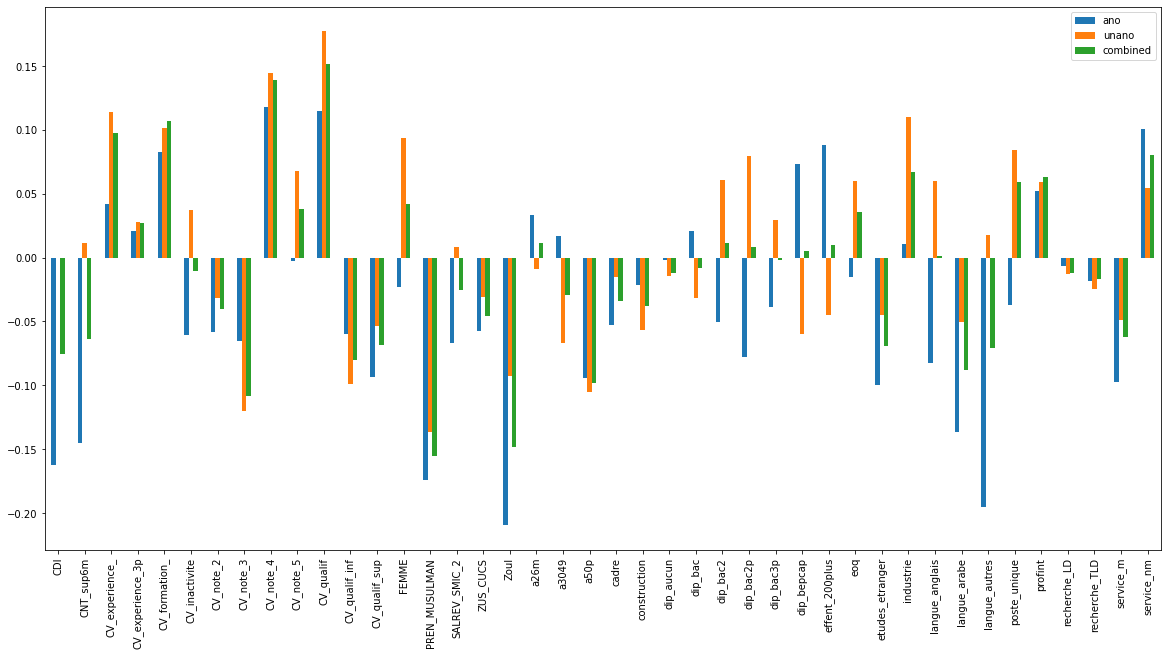

In [4]:
corrTable = pd.DataFrame()

corrTable['ano'] = X_ano.corr()['ENTRETIEN']
corrTable['unano'] = X_unano.corr()['ENTRETIEN']
corrTable['combined'] = data.corr()['ENTRETIEN']

corrTable.drop('ENTRETIEN', axis=0).plot.bar(figsize=(20,10))

In [5]:
X_ano = X_ano.drop(columns=['ENTRETIEN'])
X_unano = X_unano.drop(columns=['ENTRETIEN'])
X = X.drop(columns=['ENTRETIEN'])

### Data Preparation for models

In [6]:
# Train, Test split
# Fixed random seed for debugging to avoid random splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

# Random Forest

In [7]:
# define the model
modelForest = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(modelForest, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

modelForest.fit(X_train, y_train)

y_pred = modelForest.predict(X_test)

errors = abs(y_pred - y_test)

print('Mean Absolute Error:', round(np.mean(errors), 3), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = sum(errors) / len(errors) * 100
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 3), '%.')

Accuracy: 0.975 (0.010)
Mean Absolute Error: 0.012 degrees.
Accuracy: 98.828 %.


In [8]:
# Extract single tree
estimator = modelForest.estimators_[5]
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ['notInterviewed', 'Interviewed'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Debias Dataset

## Methodology
1. Analyse Dataset for unwanted Biases that are problematic from a legal standpoint
2. Explore Causes why the model predicts biased results
3. Unbalanced Data

    3.1 Weighed random forest (Chen et al., 2004)
    
    3.2 Oversampling
    
    3.3 Undersampling (Liu et al. 2009)
    
    
4. Test applied debias methods through testing the model with fictive 
    
#### Publication bibliography


Liu, Xu-Ying; Wu, Jianxin; Zhou, Zhi-Hua (2009): Exploratory undersampling for class-imbalance learning. In IEEE transactions on systems, man, and cybernetics. Part B, Cybernetics : a publication of the IEEE Systems, Man, and Cybernetics Society 39 (2), pp. 539–550. DOI: 10.1109/tsmcb.2008.2007853.

Using random forest to learn imbalanced data (2004). Available online at https://scholar.google.com/citations?user=5qujoo4aaaaj&hl=en&oi=sra.




## Testing Bias Random Forest

In [9]:
def compare_ratio(X, y, job_type):
    # deep copy of dataframe
    df = X.copy()
    df['y'] = y.copy()
    
    df = df[df[job_type] == 1]
    df_male = df[df['FEMME'] == 0]
    df_female = df[df['FEMME'] == 1]
    
    
    tot_female = df_female.shape[0]
    invited_female = df_female[df_female['y'] == 1].shape[0]
    female_ratio = 0 if tot_female == 0 else invited_female/ tot_female

    tot_male = df_male.shape[0]
    invited_male = df_male[df_male['y'] == 1].shape[0]
    male_ratio = 0 if tot_male == 0 else  invited_male/tot_male

    
    df_female_quali = df_female['CV_qualif']
    avg_female_quali = 0 if tot_female == 0 else  sum(df_female_quali)/tot_female
    
    df_male_quali = df_male['CV_qualif']
    avg_male_quali = 0 if tot_male == 0 else  sum(df_male_quali)/tot_male


    print('Average male qualification value: %f, are hired at a ratio of %f (total # applicants: %d), total applicants: %d' %(avg_male_quali, male_ratio, tot_male, tot_male))
    print('Average female qualification value: %f, are hired at a ratio of %f (total # applicants: %d), total applicants: %d' %(avg_female_quali, female_ratio, tot_female, tot_female))
    
def print_ratios(X, y):
    print('\n contruction:\n')

    compare_ratio(X, y, 'construction')

    print('\n service_nm:\n')

    compare_ratio(X, y, 'service_nm')

    print('\n service_m:\n')

    compare_ratio(X, y, 'service_m')

    print('\n industrie:\n')

    compare_ratio(X, y, 'industrie')


#### For the Training Data

In [10]:
print_ratios(X_train, modelForest.predict(X_train))


 contruction:

Average male qualification value: 0.693738, are hired at a ratio of 0.315789 (total # applicants: 38), total applicants: 38
Average female qualification value: 0.409078, are hired at a ratio of 0.437500 (total # applicants: 16), total applicants: 16

 service_nm:

Average male qualification value: 0.549936, are hired at a ratio of 0.500000 (total # applicants: 182), total applicants: 182
Average female qualification value: 0.652631, are hired at a ratio of 0.575758 (total # applicants: 363), total applicants: 363

 service_m:

Average male qualification value: 0.613469, are hired at a ratio of 0.469355 (total # applicants: 620), total applicants: 620
Average female qualification value: 0.587861, are hired at a ratio of 0.457471 (total # applicants: 435), total applicants: 435

 industrie:

Average male qualification value: 0.627754, are hired at a ratio of 0.578475 (total # applicants: 223), total applicants: 223
Average female qualification value: 0.561623, are hired a

#### For the Test Data

In [11]:
print_ratios(X_test, y_pred)


 contruction:

Average male qualification value: 0.666667, are hired at a ratio of 0.666667 (total # applicants: 3), total applicants: 3
Average female qualification value: 0.000000, are hired at a ratio of 0.000000 (total # applicants: 0), total applicants: 0

 service_nm:

Average male qualification value: 0.527263, are hired at a ratio of 0.700000 (total # applicants: 20), total applicants: 20
Average female qualification value: 0.671835, are hired at a ratio of 0.731707 (total # applicants: 41), total applicants: 41

 service_m:

Average male qualification value: 0.505028, are hired at a ratio of 0.412698 (total # applicants: 63), total applicants: 63
Average female qualification value: 0.515141, are hired at a ratio of 0.487179 (total # applicants: 39), total applicants: 39

 industrie:

Average male qualification value: 0.684603, are hired at a ratio of 0.562500 (total # applicants: 32), total applicants: 32
Average female qualification value: 0.611111, are hired at a ratio of 0

## Testing with modified test set 
changing the gender, .... factors and see if it affects the predictions. 

In [12]:
# returns a string with the vacancy type and details
def get_vacancy_type(row):
  ret = ""
  if row['effent_200plus']:
    ret += ', effent_200plus'
  if row['service_nm']:
    ret += ', service_nm'
  if row['service_m']:
    ret += ', service_m'
  if row['service_nm']:
    ret += ', service_nm'
  if row['industrie']:
    ret += ', industrie'
  if row['construction']:
    ret += ', construction'
  if row['cadre']:
    ret += ', cadre'
  if row['profint']:
    ret += ', profint'
  if row['eoq']:
    ret += ', eoq'
  if row['CDI']:
    ret += ', CDI'
  if row['CNT_sup6m']:
    ret += ', CNT_sup6m'
  if row['poste_unique']:
    ret += ', poste_unique'
  
  return ret

"""
effent_200plus:       Firm size greater than 200 employees (vacancy)
service_nm:       Non-market services (vacancy)
service_m:       Market services (vacancy)
industrie:       Manufacturing (vacancy)
construction:       Construction (vacancy)
cadre:       Upper occupation (vacancy)
profint:       Intermediary occupation (vacancy)
eoq:       Skilled white or blue collar (vacancy)
CDI:       Indefinite duration contract (vacancy)
CNT_sup6m:       Temporary contract for more than 6 months (vacancy)
poste_unique:       Vacnacy with only one position 
"""

'\neffent_200plus:       Firm size greater than 200 employees (vacancy)\nservice_nm:       Non-market services (vacancy)\nservice_m:       Market services (vacancy)\nindustrie:       Manufacturing (vacancy)\nconstruction:       Construction (vacancy)\ncadre:       Upper occupation (vacancy)\nprofint:       Intermediary occupation (vacancy)\neoq:       Skilled white or blue collar (vacancy)\nCDI:       Indefinite duration contract (vacancy)\nCNT_sup6m:       Temporary contract for more than 6 months (vacancy)\nposte_unique:       Vacnacy with only one position \n'

In [13]:
X_test_mod = X_test.copy()
# changing the gender from male to female and vice versa
X_test_mod['FEMME'] = 1-X_test_mod['FEMME']
y_pred_mod = modelForest.predict(X_test_mod)

print('Testset size: %d, # of changed predictions after changing the gender field: %d\n' 
      %(len(y_pred),sum(y_pred - y_pred_mod)))

fem_hired = 0
m_hired = 0
for i in range(len(y_pred)):
  if (y_pred[i] != y_pred_mod[i]):
    # get the gender of the hired person, either in the original testset or modified
    gender = X_test.iloc[i]['FEMME'] if y_pred[i] else X_test_mod.iloc[i]['FEMME']
    fem_hired = fem_hired+gender
    m_hired = m_hired+ (1-gender)
    gender = 'Female' if gender else 'Male'
    
    print('Gender: ',  gender, ',Vacancy type: ',get_vacancy_type(X_test_mod.iloc[i]),'\n\n')

print("Females hired: %d, Males hired: %d" %(fem_hired,m_hired))

Testset size: 256, # of changed predictions after changing the gender field: 7

Gender:  Male ,Vacancy type:  , effent_200plus, CDI, CNT_sup6m 


Gender:  Male ,Vacancy type:  , effent_200plus, CNT_sup6m 


Gender:  Female ,Vacancy type:  , effent_200plus, CDI, CNT_sup6m 


Gender:  Female ,Vacancy type:  , effent_200plus, service_m, eoq, CDI, CNT_sup6m, poste_unique 


Gender:  Male ,Vacancy type:  , effent_200plus, CDI, CNT_sup6m 


Gender:  Female ,Vacancy type:  , effent_200plus, CDI, CNT_sup6m 


Gender:  Female ,Vacancy type:  , effent_200plus, CNT_sup6m 


Gender:  Female ,Vacancy type:  , effent_200plus, CNT_sup6m 


Gender:  Male ,Vacancy type:  , effent_200plus 


Gender:  Female ,Vacancy type:  , effent_200plus, CNT_sup6m 


Gender:  Male ,Vacancy type:  , effent_200plus 


Females hired: 6, Males hired: 5


### Testing change in class probabilities

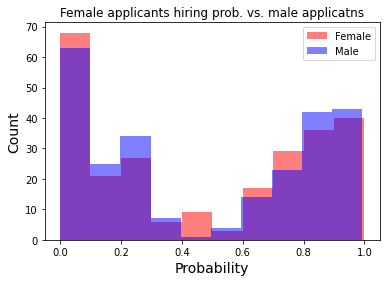

In [40]:
import matplotlib.pyplot as plt

# copying the male applicants rows and changing the gender field to female
fem_test = X_test[X_test['FEMME']==0].copy()
n_males = fem_test.shape[0]
fem_test = fem_test.assign(FEMME=1)
# appending the female applicants rows
fem_test = fem_test.append(X_test[X_test['FEMME']==1].copy())

# copy the male applicants rows
m_test = X_test[X_test['FEMME']==0].copy()
# appending the female applicants rows and changing the gender field to male
m_test = m_test.append(X_test[X_test['FEMME']==1].copy())
m_test = m_test.assign(FEMME=0)

# sanity check
#print(sum(m_test['FEMME']==1), m_test.shape,X_test.shape)

# get predictions probability for the interviewed class, for both data-subsets
fem_prob = modelForest.predict_proba(fem_test)
m_prob = modelForest.predict_proba(m_test)


# Sub-setting the interviewed class probability for the histogram.
plt.figure(figsize=(6,4))
plt.hist(fem_prob[:,0], bins=10, alpha=0.5, facecolor='r', label="Female")
plt.hist(m_prob[:,0], bins=10, alpha=0.5, facecolor='b', label="Male")

plt.xlabel("Probability", size=14)
plt.ylabel("Count", size=14)
plt.title("Female applicants hiring prob. vs. male applicatns")
plt.legend(loc='upper right')
#plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

In [46]:
print("Female Interviewed probability: %f, Male Interviewed probability: %f" %(sum(fem_prob[:,0])/fem_prob.shape[0],sum(m_prob[:,0])/m_prob.shape[0]))
print("Original: Female Interviewed probability: %f, Male Interviewed probability: %f" %(sum(fem_prob[n_males:,0])/(fem_prob.shape[0]-n_males),sum(m_prob[0:n_males,0])/n_males))
print("Modified: Female Interviewed probability: %f, Male Interviewed probability: %f" %(sum(fem_prob[0:n_males,0])/n_males,sum(m_prob[n_males:,0])/(m_prob.shape[0]-n_males)))


Female Interviewed probability: 0.463547, Male Interviewed probability: 0.468366
Original: Female Interviewed probability: 0.357214, Male Interviewed probability: 0.452576
Modified: Female Interviewed probability: 0.557370, Male Interviewed probability: 0.486261


From the above, it looks like the interview class probability changed with modifiying the gender field.

#### to be debugged - ignore this subsection for now

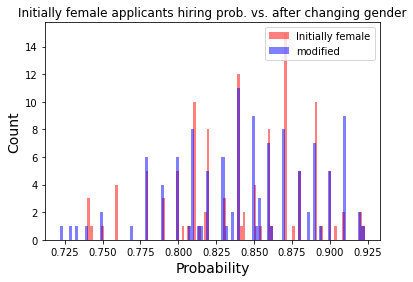

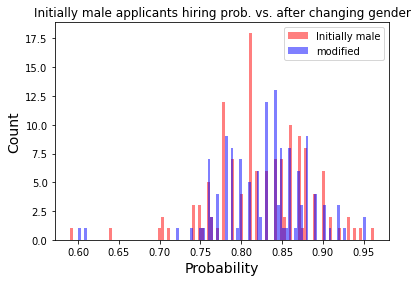

In [20]:
import matplotlib.pyplot as plt

fem_test = pd.DataFrame()
m_test = pd.DataFrame()

fem_test_mod = pd.DataFrame()
m_test_mod = pd.DataFrame()

for i, row in X_test.iterrows():
  row_mod = row.copy()
  row_mod['FEMME'] = 1-row_mod['FEMME']

  if row['FEMME']:
    fem_test = fem_test.append(row)
    m_test_mod = m_test_mod.append(row_mod)

  else: 
    m_test = m_test.append(row)
    fem_test_mod = fem_test_mod.append(row_mod)
  

fem_prob = modelForest.predict_proba(fem_test)
fem_prob_mod = modelForest.predict_proba(fem_test_mod)
m_prob = modelForest.predict_proba(m_test)
m_prob_mod = modelForest.predict_proba(m_test_mod)

# Sub-setting the interviewed class probability for the histogram.
plt.figure(figsize=(6,4))
plt.hist(fem_prob[:,0], bins=100, alpha=0.5, facecolor='r', label="Initially female")
plt.hist(m_prob_mod[:,0], bins=100, alpha=0.5, facecolor='b', label="modified")

plt.xlabel("Probability", size=14)
plt.ylabel("Count", size=14)
plt.title("Initially female applicants hiring prob. vs. after changing gender")
plt.legend(loc='upper right')
#plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

plt.figure(figsize=(6,4))
plt.hist(m_prob[:,0], bins=100, alpha=0.5, facecolor='r', label="Initially male")
plt.hist(fem_prob_mod[:,0], bins=100, alpha=0.5, facecolor='b', label="modified")

plt.xlabel("Probability", size=14)
plt.ylabel("Count", size=14)
plt.title("Initially male applicants hiring prob. vs. after changing gender")
plt.legend(loc='upper right')

**Seems like there is an error in sub-testset...** 
as in the class probabilities, the 1st element is always very high while the 2nd if very low.

In [15]:
temp_prob = modelForest.predict_proba(X_test)
temp_prob

array([[0.85      , 0.15      ],
       [0.63      , 0.37      ],
       [0.        , 1.        ],
       [0.83      , 0.17      ],
       [0.        , 1.        ],
       [0.76      , 0.24      ],
       [0.        , 1.        ],
       [0.71      , 0.29      ],
       [0.01      , 0.99      ],
       [0.9       , 0.1       ],
       [0.        , 1.        ],
       [0.82      , 0.18      ],
       [0.92      , 0.08      ],
       [0.77      , 0.23      ],
       [0.83      , 0.17      ],
       [0.        , 1.        ],
       [0.2514512 , 0.7485488 ],
       [0.92343407, 0.07656593],
       [0.85      , 0.15      ],
       [0.        , 1.        ],
       [0.71      , 0.29      ],
       [0.        , 1.        ],
       [0.94      , 0.06      ],
       [0.        , 1.        ],
       [0.88      , 0.12      ],
       [0.89      , 0.11      ],
       [0.9       , 0.1       ],
       [0.        , 1.        ],
       [0.56      , 0.44      ],
       [0.01      , 0.99      ],
       [0.

In [19]:
m_prob

array([[0.85      , 0.15      ],
       [0.75      , 0.25      ],
       [0.79      , 0.21      ],
       [0.85      , 0.15      ],
       [0.84      , 0.16      ],
       [0.74      , 0.26      ],
       [0.78      , 0.22      ],
       [0.9       , 0.1       ],
       [0.86      , 0.14      ],
       [0.88      , 0.12      ],
       [0.8       , 0.2       ],
       [0.7       , 0.3       ],
       [0.85111111, 0.14888889],
       [0.81      , 0.19      ],
       [0.93      , 0.07      ],
       [0.81      , 0.19      ],
       [0.76      , 0.24      ],
       [0.87666667, 0.12333333],
       [0.87222222, 0.12777778],
       [0.89      , 0.11      ],
       [0.78      , 0.22      ],
       [0.87      , 0.13      ],
       [0.8       , 0.2       ],
       [0.78      , 0.22      ],
       [0.79      , 0.21      ],
       [0.9       , 0.1       ],
       [0.8       , 0.2       ],
       [0.82      , 0.18      ],
       [0.91      , 0.09      ],
       [0.81      , 0.19      ],
       [0.

In [21]:
temp_prob = modelForest.predict_proba(X_test[X_test['FEMME']==1])
temp_prob

array([[0.85      , 0.15      ],
       [0.        , 1.        ],
       [0.83      , 0.17      ],
       [0.        , 1.        ],
       [0.71      , 0.29      ],
       [0.9       , 0.1       ],
       [0.77      , 0.23      ],
       [0.92343407, 0.07656593],
       [0.85      , 0.15      ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.88      , 0.12      ],
       [0.9       , 0.1       ],
       [0.        , 1.        ],
       [0.56      , 0.44      ],
       [0.01      , 0.99      ],
       [0.01      , 0.99      ],
       [0.91      , 0.09      ],
       [0.64      , 0.36      ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.92      , 0.08      ],
       [0.67      , 0.33      ],
       [0.        , 1.        ],
       [0.96      , 0.04      ],
       [0.64      , 0.36      ],
       [0.01      , 0.99      ],
       [0.        , 1.        ],
       [0.87      , 0.13      ],
       [0.

# Support Vector Machine

In [ ]:


#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred) * 100, 2), '%.')

# Neural Network

The neural network "simpleNet" is built using Keras with one input layer with the activation function relu and one output layer using a sigmoid activation function for binary classification. In addition three hidden layers are addedm, all with relu activation function.

In [47]:
# define the keras model

name="simpleNet"
model = keras.Sequential(
    [
        layers.Dense(128, input_dim=42, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.08)),
                
        layers.Dropout(0.5),
        layers.Dense(56, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(12, activation='relu'),
        
        layers.Dense(1, activation='sigmoid')  
    
    ],name=name
)
model.summary()

Model: "simpleNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5504      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 56)                7224      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1368      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13

In [48]:
from tensorflow.keras.optimizers import SGD
sgd = keras.optimizers.SGD(lr=.01, momentum=0.0, nesterov=True)


#Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.01,
                       patience=4,
                       min_lr=1e-8,
                       verbose=1)
#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",\
                                      patience=8, verbose=0, mode="auto", baseline=None, restore_best_weights=True)


model.compile(optimizer="sgd", loss="mae", metrics=["mae", 'accuracy'])

model.fit(np.array(X_train), np.array(y_train), epochs=20, callbacks=[es, lrr], validation_split=0.2, shuffle=True, verbose=2)

_, _, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/20
58/58 - 1s - loss: 0.5002 - mae: 0.5002 - accuracy: 0.5082 - val_loss: 0.5009 - val_mae: 0.5009 - val_accuracy: 0.4749
Epoch 2/20
58/58 - 0s - loss: 0.4965 - mae: 0.4965 - accuracy: 0.5185 - val_loss: 0.5006 - val_mae: 0.5006 - val_accuracy: 0.4880
Epoch 3/20
58/58 - 0s - loss: 0.4997 - mae: 0.4997 - accuracy: 0.5000 - val_loss: 0.4999 - val_mae: 0.4999 - val_accuracy: 0.4793
Epoch 4/20
58/58 - 0s - loss: 0.4969 - mae: 0.4969 - accuracy: 0.5163 - val_loss: 0.4994 - val_mae: 0.4994 - val_accuracy: 0.4815
Epoch 5/20
58/58 - 0s - loss: 0.4973 - mae: 0.4973 - accuracy: 0.5142 - val_loss: 0.4987 - val_mae: 0.4987 - val_accuracy: 0.4837
Epoch 6/20
58/58 - 0s - loss: 0.4966 - mae: 0.4966 - accuracy: 0.5114 - val_loss: 0.4979 - val_mae: 0.4979 - val_accuracy: 0.4837

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999776482583e-05.
Epoch 7/20
58/58 - 0s - loss: 0.4940 - mae: 0.4940 - accuracy: 0.5142 - val_loss: 0.4979 - val_mae: 0.4979 - val_accuracy: 0.4837
Epoch 8/2

## Modified model

In [80]:
# define the keras model

name="simpleNet_v2"
model_v2 = keras.Sequential(
    [
        #128
        layers.Dense(56, input_dim=42, activation='relu', kernel_initializer=initializers.RandomNormal(seed=1,stddev=0.08)),
              
        #layers.Dropout(0.5),
        #layers.Dense(56, activation='relu'),
        layers.Dense(24, activation='relu'),
        #layers.Dropout(0.2),
        layers.Dense(12, activation='relu'),
        
        layers.Dense(1, activation='sigmoid')  
    
    ],name=name
)
model_v2.summary()

Model: "simpleNet_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 56)                2408      
_________________________________________________________________
dense_11 (Dense)             (None, 24)                1368      
_________________________________________________________________
dense_12 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 13        
Total params: 4,089
Trainable params: 4,089
Non-trainable params: 0
_________________________________________________________________


In [81]:
#sgd = keras.optimizers.SGD(lr=.01, momentum=0.0, nesterov=True)
import random
random.seed(1)
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

#Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor='val_loss',
                       factor=.01,
                       patience=4,
                       min_lr=1e-8,
                       verbose=1)
#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",\
                                      patience=8, verbose=0, mode="auto", baseline=None, restore_best_weights=True)


model_v2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mse", 'accuracy'])

model_v2.fit(np.array(X_train), np.array(y_train), epochs=100, callbacks=[es, lrr], validation_split=0.2, shuffle=True, verbose=2)

_, _, accuracy = model_v2.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/100
58/58 - 1s - loss: 0.6788 - mse: 0.2429 - accuracy: 0.5703 - val_loss: 0.6668 - val_mse: 0.2370 - val_accuracy: 0.5817
Epoch 2/100
58/58 - 0s - loss: 0.6489 - mse: 0.2285 - accuracy: 0.6253 - val_loss: 0.6419 - val_mse: 0.2258 - val_accuracy: 0.6144
Epoch 3/100
58/58 - 0s - loss: 0.6211 - mse: 0.2159 - accuracy: 0.6514 - val_loss: 0.6147 - val_mse: 0.2133 - val_accuracy: 0.6340
Epoch 4/100
58/58 - 0s - loss: 0.5928 - mse: 0.2033 - accuracy: 0.6830 - val_loss: 0.5953 - val_mse: 0.2054 - val_accuracy: 0.6645
Epoch 5/100
58/58 - 0s - loss: 0.5616 - mse: 0.1895 - accuracy: 0.7184 - val_loss: 0.5696 - val_mse: 0.1936 - val_accuracy: 0.7124
Epoch 6/100
58/58 - 0s - loss: 0.5240 - mse: 0.1744 - accuracy: 0.7505 - val_loss: 0.5417 - val_mse: 0.1817 - val_accuracy: 0.7429
Epoch 7/100
58/58 - 0s - loss: 0.4827 - mse: 0.1574 - accuracy: 0.7827 - val_loss: 0.5119 - val_mse: 0.1689 - val_accuracy: 0.7778
Epoch 8/100
58/58 - 0s - loss: 0.4276 - mse: 0.1345 - accuracy: 0.8268 - val_loss: 

Make predictions on test data and show confusion materix.

In [94]:
from sklearn.metrics import confusion_matrix

# making a prediction on test data
y_test_pred = model_v2.predict(X_test)
# converting the sigmoid output to binary class
y_test_pred = [1 if y_test_pred[i]>0.5  else 0 for i in range(len(y_test_pred))]

errors = abs(y_test.to_numpy() - y_test_pred)
print('Mean Square Error:', round(np.mean(errors), 3), 'degrees.')

# Calculate mean sequre percentage error (MAPE)
mape = 0 if len(errors) == 0 else (sum(errors) / len(errors) * 100)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 3), '%.')
confusion_matrix(y_test.to_numpy(), y_test_pred)

Mean Square Error: 0.055 degrees.
Accuracy: 94.531 %.


array([[112,  13],
       [  1, 130]])